In [230]:
import os
import re
import zipfile
import pandas as pd
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

## Data Read and Prep

In [17]:
data_path = '/content/drive/MyDrive/Speech project/torgo_dataset/'  # Path to extract files

# Data Reading
directory = data_path

data_headmic = []
data_arraymic = []

# Regular expression patterns (case-insensitive)
pattern_male_with_dysarthria = r'M0'
pattern_male_without_dysarthria = r'MC0'
pattern_female_with_dysarthria = r'F0'
pattern_female_without_dysarthria = r'FC0'
pattern_arrayMic = r'arrayMic'
pattern_headMic = r'headMic'

# Iterate over the files in the directory and its subfolders
for root, dirs, files in os.walk(directory):
    for filename in files:
        if filename.endswith('.wav'):  # Process only .wav files
            filepath = os.path.join(root, filename)

            # Extract information from the filename using regular expressions
            is_male_with_dysarthria = bool(re.search(pattern_male_with_dysarthria, filename, re.IGNORECASE))
            is_male_without_dysarthria = bool(re.search(pattern_male_without_dysarthria, filename, re.IGNORECASE))
            is_female_with_dysarthria = bool(re.search(pattern_female_with_dysarthria, filename, re.IGNORECASE))
            is_female_without_dysarthria = bool(re.search(pattern_female_without_dysarthria, filename, re.IGNORECASE))
            is_arraymic = bool(re.search(pattern_arrayMic, filename, re.IGNORECASE))
            is_headmic = bool(re.search(pattern_headMic, filename, re.IGNORECASE))

            # Determine gender and condition
            gender = 'male' if is_male_with_dysarthria or is_male_without_dysarthria else 'female'
            condition = 'with_dysarthria' if is_male_with_dysarthria or is_female_with_dysarthria else 'without_dysarthria'

            # Append the data to the corresponding list based on microphone type
            if is_arraymic:
                data_arraymic.append([gender, condition, filepath])
            elif is_headmic:
                data_headmic.append([gender, condition, filepath])

In [18]:
df_data = pd.DataFrame(data_arraymic + data_headmic, columns=['gender', 'condition', 'filepath'])
df_data['label'] = df_data['condition'].map({'with_dysarthria': 1, 'without_dysarthria': 0})
print("Dataframe created with shape:", df_data.shape)

Dataframe created with shape: (17633, 4)


## Data Patterns

In [19]:
df_data.head()

,gender,condition,filepath,label
0,female,without_dysarthria,/content/drive/MyDrive/Speech project/torgo_da...,0
1,female,without_dysarthria,/content/drive/MyDrive/Speech project/torgo_da...,0
2,female,without_dysarthria,/content/drive/MyDrive/Speech project/torgo_da...,0
3,female,without_dysarthria,/content/drive/MyDrive/Speech project/torgo_da...,0
4,female,without_dysarthria,/content/drive/MyDrive/Speech project/torgo_da...,0


In [20]:
df_data['condition'].value_counts(normalize=True)

,proportion
condition,
without_dysarthria,0.649634
with_dysarthria,0.350366


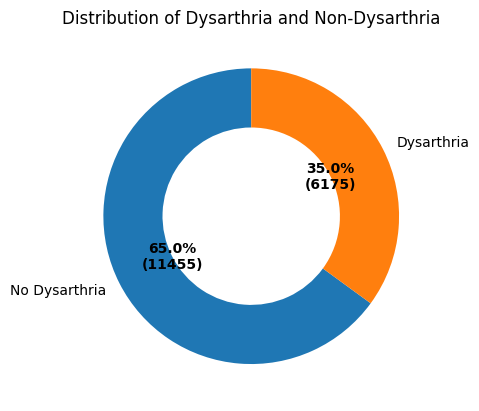

In [135]:
labels = ['No Dysarthria', 'Dysarthria']
values = [
    df_data[df_data['label'] == 0].shape[0],  # Count of 'without_dysarthria'
    df_data[df_data['label'] == 1].shape[0]   # Count of 'with_dysarthria'
]


percentages = [value / sum(values) * 100 for value in values]


fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(
    values,
    labels=labels,
    autopct=lambda p: f'{p:.1f}%\n({int(p * sum(values) / 100)})',
    startangle=90,
    wedgeprops=dict(width=0.4)
)


plt.setp(autotexts, size=10, weight="bold")
ax.set_title("Distribution of Dysarthria and Non-Dysarthria")

# Display the chart
plt.show()

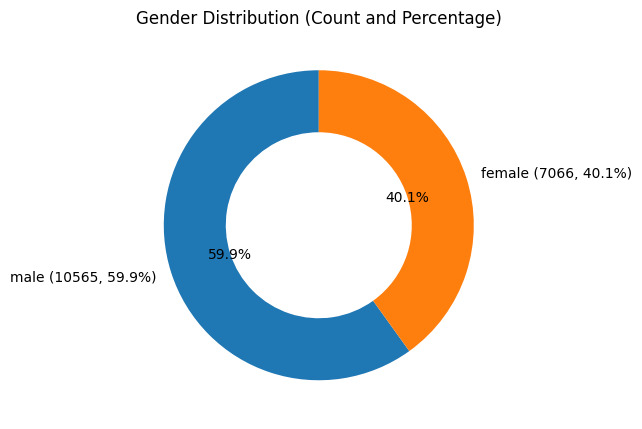

In [136]:
# Data for the donut chart
gender_counts = df_data['gender'].value_counts()
gender_labels = gender_counts.index
gender_values = gender_counts.values

# Calculate percentages
gender_percentages = gender_values / gender_values.sum() * 100
labels_with_info = [f"{label} ({count}, {percent:.1f}%)" for label, count, percent in zip(gender_labels, gender_values, gender_percentages)]

# Donut chart
plt.figure(figsize=(5, 6))
plt.pie(gender_values, labels=labels_with_info, autopct='%1.1f%%', startangle=90, wedgeprops={'width': 0.4})
plt.title("Gender Distribution (Count and Percentage)")
plt.show()


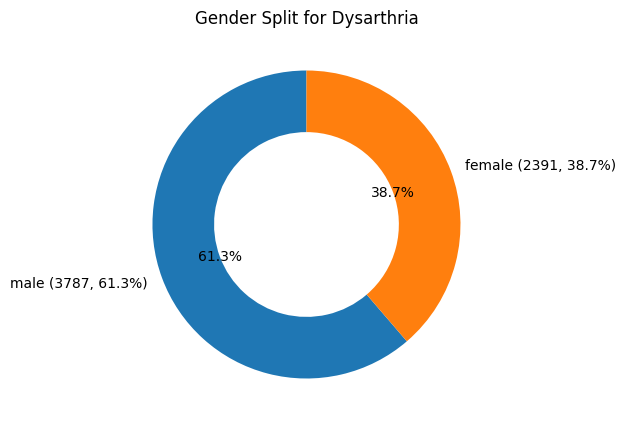

In [23]:
# Filter data for rows with dysarthria
dysarthria_data = df_data[df_data['condition'] == 'dysarthria']

# Count the number of males and females with dysarthria
gender_dysarthria_counts = dysarthria_data['gender'].value_counts()
gender_labels = gender_dysarthria_counts.index
gender_values = gender_dysarthria_counts.values

# Calculate percentages
gender_percentages = gender_values / gender_values.sum() * 100
labels_with_info = [f"{label} ({count}, {percent:.1f}%)" for label, count, percent in zip(gender_labels, gender_values, gender_percentages)]

# Donut chart
plt.figure(figsize=(5, 5))
plt.pie(gender_values, labels=labels_with_info, autopct='%1.1f%%', startangle=90, wedgeprops={'width': 0.4})
plt.title("Gender Split for Dysarthria")
plt.show()


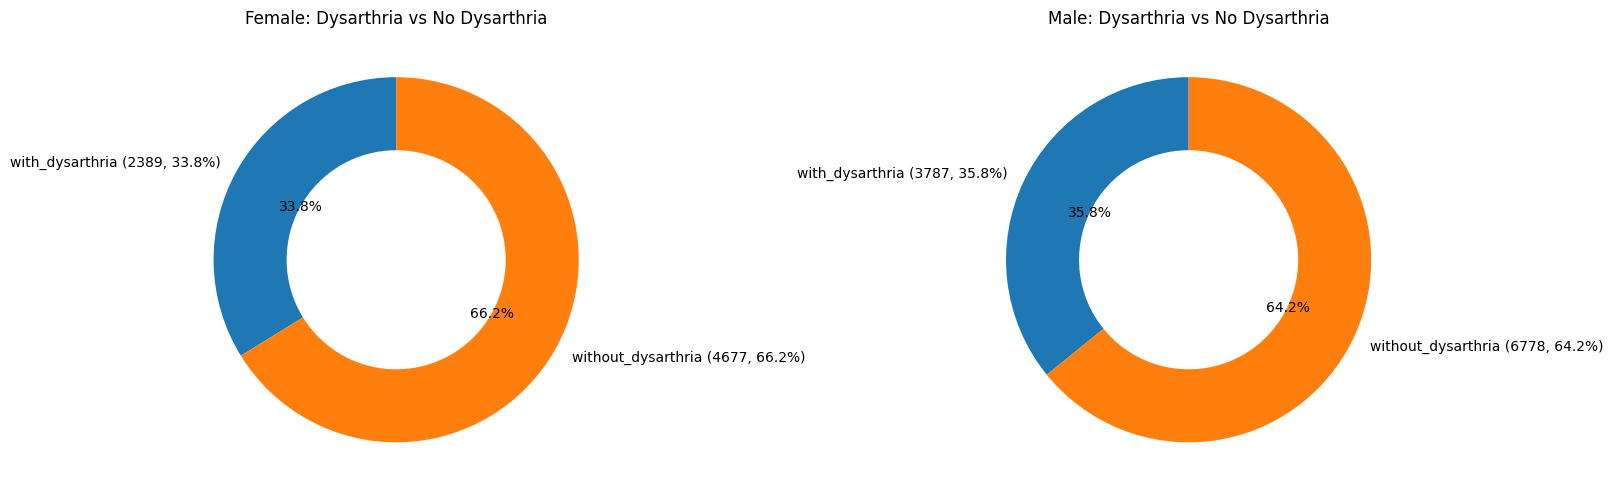

In [137]:
# Group data by gender and condition
gender_condition_counts = df_data.groupby(['gender', 'condition']).size()

# Data for females
female_counts = gender_condition_counts['female']
female_labels = female_counts.index
female_values = female_counts.values

# Calculate percentages for females
female_percentages = female_values / female_values.sum() * 100
female_labels_with_info = [f"{label} ({count}, {percent:.1f}%)" for label, count, percent in zip(female_labels, female_values, female_percentages)]

# Data for males
male_counts = gender_condition_counts['male']
male_labels = male_counts.index
male_values = male_counts.values

# Calculate percentages for males
male_percentages = male_values / male_values.sum() * 100
male_labels_with_info = [f"{label} ({count}, {percent:.1f}%)" for label, count, percent in zip(male_labels, male_values, male_percentages)]

# Plot side-by-side donut charts
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Female donut chart
axes[0].pie(female_values, labels=female_labels_with_info, autopct='%1.1f%%', startangle=90, wedgeprops={'width': 0.4})
axes[0].set_title("Female: Dysarthria vs No Dysarthria")

# Male donut chart
axes[1].pie(male_values, labels=male_labels_with_info, autopct='%1.1f%%', startangle=90, wedgeprops={'width': 0.4})
axes[1].set_title("Male: Dysarthria vs No Dysarthria")

# Show the plots
plt.tight_layout()
plt.show()


## Feature Engineering - Extracting MFCC

In [25]:
# Feature Engineering with Padding for Short Files and Error Tracking
error_count = 0
short_count = 0
total_files = len(df_data)  # Total number of audio files

def extract_mfcc(filepath, sr=22050, n_mfcc=13, target_length=2048):
    """
    Extract MFCC features from an audio file with padding for short files.
    """
    global error_count  # Global error count
    global short_count  # Global short file count
    try:
        # Load the audio file
        audio, _ = librosa.load(filepath, sr=sr)

        # Pad the audio to ensure the minimum required length
        if len(audio) < target_length:
            short_count += 1  # Increment the short file count
            padding = target_length - len(audio)
            audio = np.pad(audio, (0, padding), mode='constant')

        # Compute MFCCs
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, n_fft=target_length)
        return np.mean(mfccs, axis=1)  # Mean MFCC values

    except Exception as e:
        # Increment the error count and log the error
        error_count += 1
        print(f"Error extracting MFCCs from {filepath}: {e}")
        return None


In [26]:
print("Extracting MFCC features...")
df_data['features'] = df_data['filepath'].apply(lambda x: extract_mfcc(x))

Extracting MFCC features...


<ipython-input-25-85db741c0a47>:14: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, _ = librosa.load(filepath, sr=sr)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error extracting MFCCs from /content/drive/MyDrive/Speech project/torgo_dataset/F_Dys/wav_headMic_F01/wav_headMic_F01_0067.wav: 
Error extracting MFCCs from /content/drive/MyDrive/Speech project/torgo_dataset/F_Dys/wav_headMic_F01/wav_headMic_F01_0068.wav: 


In [27]:
# Report errors
print(f"\nTotal files processed: {total_files}")
print(f"Total files with errors: {error_count}")
print(f"Percentage of errors: {100 * error_count / total_files:.2f}%")


Total files processed: 17633
Total files with errors: 2
Percentage of errors: 0.01%


In [28]:
# Count rows with incorrect and correct feature sizes
incorrect_size_count = df_data['features'].apply(lambda x: x is None or len(x) != 13).sum()
correct_size_count = df_data['features'].apply(lambda x: x is not None and len(x) == 13).sum()

# Print counts
print(f"Total rows in dataset: {len(df_data)}")
print(f"Rows with correct feature size: {correct_size_count}")
print(f"Rows with incorrect feature size: {incorrect_size_count}")

# Filter out rows with incorrect feature size
df_data = df_data[df_data['features'].apply(lambda x: x is not None and len(x) == 13)]

# Print the size of the dataset after filtering
print(f"Dataset size after filtering: {len(df_data)}")

Total rows in dataset: 17633
Rows with correct feature size: 17631
Rows with incorrect feature size: 2
Dataset size after filtering: 17631


In [35]:
# Copy of the original DataFrame to avoid overwriting
df_transformed = df_data.copy()

# Expand the 'features' column into separate columns named M1 to M13
mfcc_columns = [f'M{i+1}' for i in range(13)]  # Generate column names M1 to M13
mfcc_expanded = pd.DataFrame(df_transformed['features'].tolist(), columns=mfcc_columns)

# 0 for male and 1 for female
df_transformed['gender_mapped'] = df_transformed['gender'].map({'male': 0, 'female': 1}).astype(int)

# Combine the expanded MFCC columns with the original DataFrame
df_transformed = pd.concat([df_transformed, mfcc_expanded], axis=1)

In [36]:
df_transformed.head()

,gender,condition,filepath,label,features,gender_mapped,M1,M2,M3,M4,M5,M6,M7,M8,M9,M10,M11,M12,M13
0,female,without_dysarthria,/content/drive/MyDrive/Speech project/torgo_da...,0.0,"[-358.84335, 71.04295, -32.117542, 42.714172, ...",1.0,-358.843353,71.042953,-32.117542,42.714172,-17.732943,25.136646,-36.299854,22.689983,-22.859261,-7.145495,0.720612,-8.173335,-4.656964
1,female,without_dysarthria,/content/drive/MyDrive/Speech project/torgo_da...,0.0,"[-343.88675, 82.971405, -40.797176, 39.157413,...",1.0,-343.886749,82.971405,-40.797176,39.157413,-14.799722,25.428030,-43.460384,24.068468,-19.959249,-8.992933,-1.912487,-8.741645,-5.621877
2,female,without_dysarthria,/content/drive/MyDrive/Speech project/torgo_da...,0.0,"[-462.88156, 46.607544, -27.719397, 63.342495,...",1.0,-462.881561,46.607544,-27.719397,63.342495,-48.534657,52.226501,-42.370602,35.662411,-14.626758,8.518962,-2.678352,-0.215523,14.844447
3,female,without_dysarthria,/content/drive/MyDrive/Speech project/torgo_da...,0.0,"[-332.15466, 102.166664, -25.712492, 50.536175...",1.0,-332.154663,102.166664,-25.712492,50.536175,-11.837389,34.544975,-33.452698,26.458591,-19.854198,-1.522977,4.753811,-6.369249,-4.985842
4,female,without_dysarthria,/content/drive/MyDrive/Speech project/torgo_da...,0.0,"[-422.30457, 49.9119, -27.106886, 43.812088, -...",1.0,-422.304565,49.911900,-27.106886,43.812088,-34.403488,41.976273,-41.110710,21.874905,-15.505911,4.716015,-0.770872,-1.581828,10.786043


In [37]:
# df_transformed.to_csv('/content/drive/MyDrive/Speech project/backup/df_transformed.csv', index=False)

In [75]:
# df_transformed_b = pd.read_csv('/content/drive/MyDrive/Speech project/backup/df_transformed.csv')

In [88]:
final_df = df_transformed.drop(columns=['filepath', 'gender', 'condition', 'features'])

In [89]:
final_df.head()

,label,gender_mapped,M1,M2,M3,M4,M5,M6,M7,M8,M9,M10,M11,M12,M13
0,0.0,1.0,-358.843353,71.042953,-32.117542,42.714172,-17.732943,25.136646,-36.299854,22.689983,-22.859261,-7.145495,0.720612,-8.173335,-4.656964
1,0.0,1.0,-343.886749,82.971405,-40.797176,39.157413,-14.799722,25.428030,-43.460384,24.068468,-19.959249,-8.992933,-1.912487,-8.741645,-5.621877
2,0.0,1.0,-462.881561,46.607544,-27.719397,63.342495,-48.534657,52.226501,-42.370602,35.662411,-14.626758,8.518962,-2.678352,-0.215523,14.844447
3,0.0,1.0,-332.154663,102.166664,-25.712492,50.536175,-11.837389,34.544975,-33.452698,26.458591,-19.854198,-1.522977,4.753811,-6.369249,-4.985842
4,0.0,1.0,-422.304565,49.911900,-27.106886,43.812088,-34.403488,41.976273,-41.110710,21.874905,-15.505911,4.716015,-0.770872,-1.581828,10.786043


In [204]:
final_df = final_df.dropna()

## Train test split

In [260]:
# Train-Test Split and Model Training

X_train, X_test, y_train, y_test = train_test_split(final_df.drop('label',axis=1), final_df['label'], test_size=0.3, random_state=42)

## Feature Engineering - Dysarthria Gender Split

In [261]:
# Dysarthria Gender Split feature

X_train['label'] = y_train

gender_label_avg = X_train.groupby("gender_mapped")['label'].mean().to_dict()

X_train["gl_avg"] = X_train["gender_mapped"].map(gender_label_avg)
X_test["gl_avg"] = X_test["gender_mapped"].map(gender_label_avg)

In [262]:
X_train.drop(columns=["label","gender_mapped"],inplace=True)
X_test.drop(columns=["gender_mapped"],inplace=True)

In [266]:
X_train.columns

Index(['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'M10', 'M11',
       'M12', 'M13', 'gl_avg'],
      dtype='object')

In [267]:
X_test.columns

Index(['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'M10', 'M11',
       'M12', 'M13', 'gl_avg'],
      dtype='object')

## Modeling: LGBM

In [265]:
# LightGBM dataset with feature names
feature_names = X_train.columns.tolist()

lgb_train = lgb.Dataset(X_train, label=y_train, feature_name=feature_names)
lgb_test = lgb.Dataset(X_test, label=y_test, reference=lgb_train)

In [212]:
# Parameters for the LightGBM model
params = {
    'objective': 'binary',           # Binary classification
    'metric': 'binary_logloss',      # Log loss metric
    'boosting_type': 'gbdt',         # Gradient Boosting Decision Tree
    'num_leaves': 31,                # Maximum number of leaves in one tree
    'learning_rate': 0.05,           # Step size for updates
    'feature_fraction': 0.9,          # Percentage of features used per tree
    'n_jobs': -1 ,
    'verbose': -1
}


In [213]:
# Train the model
print("Training LightGBM model...")
lgbm_model = lgb.train(
    params,
    lgb_train,
    num_boost_round=1000,              # Maximum number of boosting iterations
    valid_sets=[lgb_train, lgb_test],  # Validation sets for evaluation
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),  # Early stopping after 50 rounds
        lgb.log_evaluation(period=50)           # Log progress every 50 iterations
    ]
)

Training LightGBM model...
Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.238082	valid_1's binary_logloss: 0.266394
[100]	training's binary_logloss: 0.155435	valid_1's binary_logloss: 0.197528
[150]	training's binary_logloss: 0.119687	valid_1's binary_logloss: 0.172711
[200]	training's binary_logloss: 0.0961342	valid_1's binary_logloss: 0.158532
[250]	training's binary_logloss: 0.0793581	valid_1's binary_logloss: 0.150068
[300]	training's binary_logloss: 0.0662734	valid_1's binary_logloss: 0.145185
[350]	training's binary_logloss: 0.0558909	valid_1's binary_logloss: 0.141282
[400]	training's binary_logloss: 0.0469998	valid_1's binary_logloss: 0.138332
[450]	training's binary_logloss: 0.0396153	valid_1's binary_logloss: 0.136051
[500]	training's binary_logloss: 0.0333767	valid_1's binary_logloss: 0.133622
[550]	training's binary_logloss: 0.0280995	valid_1's binary_logloss: 0.132508
[600]	training's binary_logloss: 0.0236637	valid_1's binar

In [214]:
# # Save the model for deployment
# lgbm_model.save_model('/content/drive/MyDrive/Speech project/lightgbm_model.txt')

## Make Predictions

In [215]:
# Make predictions
y_pred_proba = lgbm_model.predict(X_test)  # Predicted probabilities
y_pred = (y_pred_proba > 0.5).astype(int)  # Convert probabilities to binary predictions

## Model Evaluation

In [222]:
# Evaluate the model
target_names = ['Non Dysarthria', 'Dysarthria']

# Custom target names
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))


Classification Report:
                precision    recall  f1-score   support

Non Dysarthria       0.95      0.98      0.96      3446
    Dysarthria       0.95      0.90      0.93      1843

      accuracy                           0.95      5289
     macro avg       0.95      0.94      0.95      5289
  weighted avg       0.95      0.95      0.95      5289



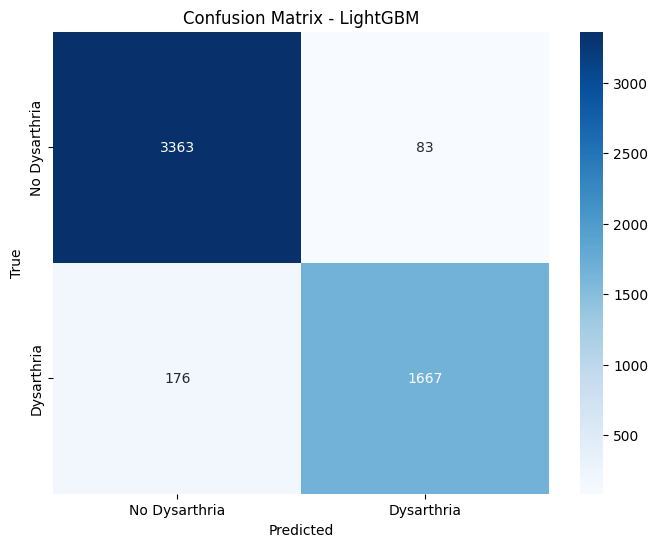

In [217]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Dysarthria', 'Dysarthria'], yticklabels=['No Dysarthria', 'Dysarthria'])
plt.title("Confusion Matrix - LightGBM")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [224]:
# # Gain-based importance
# gain_importance = lgbm_model.feature_importance(importance_type='gain')

# # Feature names
# feature_names = lgb_train.feature_name

# # Plot Gain-based Feature Importance
# plt.figure(figsize=(10, 6))
# plt.barh(feature_names, gain_importance)
# plt.xlabel("Gain Importance")
# plt.ylabel("Features")
# plt.title("Gain-based Feature Importance")
# plt.show()

In [225]:
# import shap

# explainer = shap.TreeExplainer(lgbm_model)
# shap_values = explainer.shap_values(X_test)

# # Summary plot of SHAP values
# shap.summary_plot(shap_values, X_test, feature_names=feature_names)
